In [1]:
import sys, os

import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../../data/raw/signal/EUR_USD Historical Data.csv")

In [3]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by=["Date"]).reset_index(drop=True)

In [4]:
df

,Date,Price,Open,High,Low,Change %
0,2013-01-01,1.3205,1.3194,1.3220,1.3180,0.07%
1,2013-01-02,1.3186,1.3205,1.3302,1.3157,-0.14%
2,2013-01-03,1.3048,1.3187,1.3192,1.3046,-1.05%
3,2013-01-04,1.3069,1.3048,1.3091,1.2999,0.16%
4,2013-01-07,1.3117,1.3072,1.3121,1.3018,0.37%
...,...,...,...,...,...,...
2344,2021-12-27,1.1325,1.1318,1.1335,1.1302,0.07%
2345,2021-12-28,1.1309,1.1329,1.1335,1.1289,-0.14%
2346,2021-12-29,1.1348,1.1310,1.1370,1.1273,0.34%
2347,2021-12-30,1.1323,1.1349,1.1360,1.1298,-0.22%


In [5]:
df.describe()

,Price,Open,High,Low
count,2349.000000,2349.000000,2349.000000,2349.000000
mean,1.180983,1.181058,1.185360,1.176829
std,0.090639,0.090645,0.090436,0.090694
min,1.038700,1.038900,1.041900,1.034100
25%,1.115100,1.115100,1.119400,1.111400
50%,1.156300,1.155900,1.160800,1.152700
75%,1.223900,1.224200,1.228400,1.220900
max,1.393400,1.393300,1.399300,1.391000


In [6]:
df.shape

(2349, 6)

## Obtaining the threshold_upper_bound

In [7]:
df["diff_1"] = df["Price"] - df["Price"].shift(1)

In [8]:
df["diff_1"]

0          NaN
1      -0.0019
2      -0.0138
3       0.0021
4       0.0048
         ...  
2344    0.0008
2345   -0.0016
2346    0.0039
2347   -0.0025
2348    0.0045
Name: diff_1, Length: 2349, dtype: float64

In [11]:
diff1 = df["diff_1"].dropna()
diff1 = diff1.reset_index(drop=True)

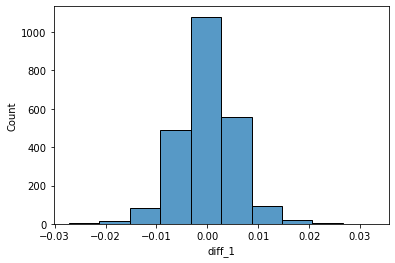

In [13]:
sns.histplot(diff1, bins=10)
plt.show()

In [15]:
bin_count, bin_edges = np.histogram(diff1, bins=10)

In [18]:
bin_count

array([   5,   16,   85,  488, 1080,  556,   94,   18,    4,    2],
      dtype=int64)

In [20]:
bin_edges

array([-0.0272 , -0.02122, -0.01524, -0.00926, -0.00328,  0.0027 ,
        0.00868,  0.01466,  0.02064,  0.02662,  0.0326 ])

In [16]:
bin_max_diff = bin_edges[1:]

In [19]:
bin_max_diff

array([-0.02122, -0.01524, -0.00926, -0.00328,  0.0027 ,  0.00868,
        0.01466,  0.02064,  0.02662,  0.0326 ])

In [17]:
bin_count

array([   5,   16,   85,  488, 1080,  556,   94,   18,    4,    2],
      dtype=int64)

In [21]:
idx_desc = np.argsort(bin_count)[::-1]

In [23]:
idx_desc

array([4, 5, 3, 6, 2, 7, 1, 0, 8, 9], dtype=int64)

In [24]:
bin_count = bin_count[idx_desc]
bin_max_diff = bin_max_diff[idx_desc]

In [25]:
bin_count

array([1080,  556,  488,   94,   85,   18,   16,    5,    4,    2],
      dtype=int64)

In [26]:
bin_max_diff

array([ 0.0027 ,  0.00868, -0.00328,  0.01466, -0.00926,  0.02064,
       -0.01524, -0.02122,  0.02662,  0.0326 ])

In [47]:
temp_sum = 0
sum_bin_counts = sum(bin_count)
curr_bin = 1

found = False

while not found and curr_bin< len(bin_edges):
    temp_sum += bin_count[curr_bin - 1]
    if temp_sum / sum_bin_counts > 0.85:
        found = True
    else:
        curr_bin += 1


In [28]:
threshold_upper_bound = max(bin_max_diff[:curr_bin+1])
threshold_upper_bound 

0.014659999999999944

## Entropy

In [31]:
def get_entropy(diff, labels):
    curr_entropy = 0.0
    total_count = len(diff)

    for label in np.unique(labels):
        curr_label_count = len(diff[labels==label])
        label_prob = curr_label_count / total_count
        curr_entropy += label_prob * math.log(label_prob)

    curr_entropy = -curr_entropy
    curr_entropy
    return curr_entropy

In [36]:
temp_threshold = 0
best_threshold = 0
best_entropy = -math.inf

while temp_threshold < threshold_upper_bound:
    curr_labels = np.zeros(len(diff1))
    idx_increase = diff1[diff1>temp_threshold].index
    idx_descrease = diff1[diff1 < -temp_threshold].index

    curr_labels[idx_increase] = 2
    curr_labels[idx_descrease] = 1

    curr_entropy = get_entropy(diff1, curr_labels)

    if curr_entropy > best_entropy:
        best_entropy = curr_entropy
        best_threshold = temp_threshold
        print(best_entropy, best_threshold)
    
    temp_threshold += 0.00001


0.7430756359101289 0
0.7993283341655697 0.0001
0.8017693479908737 0.00011
0.8448094920223177 0.0002
0.8478156510242287 0.00021
0.880377092776202 0.00030000000000000014
0.882972279713704 0.00031000000000000016
0.8995846656349775 0.0004000000000000004
0.9066916761465714 0.0004100000000000004
0.9231859580848201 0.0005000000000000007
0.9302993870666674 0.0005100000000000007
0.9559616022821377 0.0006000000000000009
0.9650161670355704 0.000610000000000001
0.9742178392600689 0.0007000000000000012
0.9861534546988201 0.0007100000000000012
0.9997493820968056 0.0008000000000000014
1.0058955136051841 0.0008100000000000015
1.0165869870096298 0.0009000000000000017
1.0272696226275992 0.0009100000000000017
1.0333909625132442 0.001000000000000002
1.040245865946416 0.001010000000000002
1.0456772878624907 0.0011000000000000022
1.0517268028642008 0.0011100000000000023
1.0587720285987088 0.0012000000000000025
1.0666823222287216 0.0012100000000000025
1.0691101403096268 0.0013000000000000028
1.07697686989397

In [34]:
best_threshold

0.0019100000000000044

## Final dataset labels

In [40]:
labels = np.zeros(len(diff1))
idx_increase = diff1[diff1>best_threshold].index
idx_descrease = diff1[diff1 < -best_threshold].index

labels[idx_increase] = 2
labels[idx_descrease] = 1

# Account for the first data point that does not have a difference
labels = np.insert(labels, 0, np.nan)

In [42]:
df["label"] = labels

In [43]:
df

,Date,Price,Open,High,Low,Change %,diff_1,label
0,2013-01-01,1.3205,1.3194,1.3220,1.3180,0.07%,NaN,NaN
1,2013-01-02,1.3186,1.3205,1.3302,1.3157,-0.14%,-0.0019,0.0
2,2013-01-03,1.3048,1.3187,1.3192,1.3046,-1.05%,-0.0138,1.0
3,2013-01-04,1.3069,1.3048,1.3091,1.2999,0.16%,0.0021,2.0
4,2013-01-07,1.3117,1.3072,1.3121,1.3018,0.37%,0.0048,2.0
...,...,...,...,...,...,...,...,...
2344,2021-12-27,1.1325,1.1318,1.1335,1.1302,0.07%,0.0008,0.0
2345,2021-12-28,1.1309,1.1329,1.1335,1.1289,-0.14%,-0.0016,0.0
2346,2021-12-29,1.1348,1.1310,1.1370,1.1273,0.34%,0.0039,2.0
2347,2021-12-30,1.1323,1.1349,1.1360,1.1298,-0.22%,-0.0025,1.0


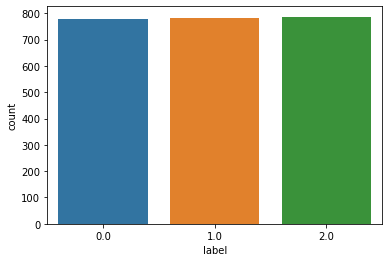

In [44]:
sns.countplot(x = "label", data=df)
plt.show()

## Export to CSV file

In [45]:
output_path = os.path.relpath("../../data/processed/EUR_USD_Labelled_v1.csv")
output_path

'..\\..\\data\\processed\\EUR_USD_Labelled_v1.csv'

In [46]:
df.to_csv(output_path, header=True, index=False)